# Module: braggdiskdetection

This module contains functions finding the positions of the Bragg disks in a 4DSTEM scan.  Generally this will involve two steps: getting a vacuum probe, then finding the Bragg disks using the vacuum probe as a template. 

## Submodule: diskdetection

The notebook demos functions related to finding the Bragg disks.  Using a vacuum probe as a template - i.e. a convolution kernel - a cross correlation (or phase or hybrid correlation) is taken between each DP and the template, and the positions and intensities of all local corraltion maxima are used to identify the Bragg disks.  Erroneous peaks are filtered out with several types of threshold.  Detected Bragg disks are generally stored in PointLists (when run on only selected DPs) or PointListArrays (when run on a full DataCube).

This notebook demos:
* Disk detection on single or selected diffraction patterns
* Disk detection on all diffraction patterns
* Additional filtering of detected Bragg disks

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt

from py4DSTEM.process.braggdiskdetection import find_Bragg_disks_single_DP
from py4DSTEM.process.braggdiskdetection import find_Bragg_disks_selected
from py4DSTEM.process.braggdiskdetection import find_Bragg_disks

In [2]:
# Load data
fp = "/home/ben/Data/20180905_FePO4_unlithiated/raw/Stack1_57x47+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm4"
dc = py4DSTEM.readwrite.read(fp)
dc.set_scan_shape(47,57)
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

# Load the template
fp_probetemplate = "/home/ben/Data/20180905_FePO4_unlithiated/processing/vacuum_probe_kernel.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_probetemplate, rawdatacube=dc)
browser.show_dataobjects()
probe_kernel = browser.get_dataobject(0)

/home/ben/Data/20180905_FePO4_unlithiated/raw/Stack1_57x47+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm4 is not a py4DSTEM file.  Reading with hyperspy...
 Index                  Name                        Type        
   0    probe_kernel                        DiffractionSlice    


#### Single DP

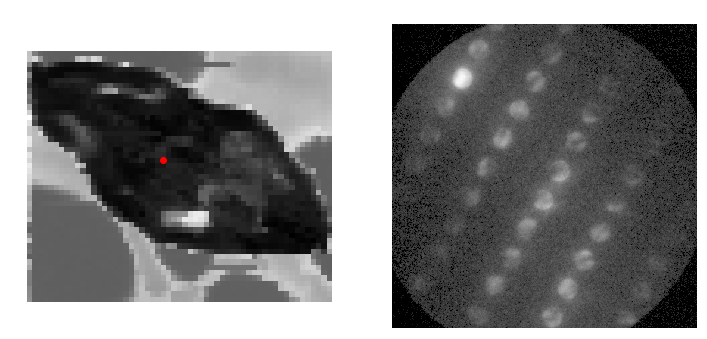

In [3]:
# Select a DP

Rx=20
Ry=25
power=0.3

DP = dc.data4D[Rx,Ry,:,:]

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,12))
ax1.matshow(np.average(dc.data4D,axis=(2,3)))
ax1.scatter(Ry,Rx,color='r')
ax2.matshow(DP**power)
ax1.axis('off')
ax2.axis('off')
plt.show()

In [5]:
# Get peaks

corrPower = 0.9
sigma = 2
edgeBoundary = 20
maxNumPeaks = 70
minPeakSpacing = 30
minRelativeIntensity = 0.005

peaks = find_Bragg_disks_single_DP(DP, probe_kernel.data2D,
                                   corrPower=corrPower,
                                   sigma=sigma,
                                   edgeBoundary=edgeBoundary,
                                   minRelativeIntensity=minRelativeIntensity,
                                   minPeakSpacing=minPeakSpacing,
                                   maxNumPeaks=maxNumPeaks)

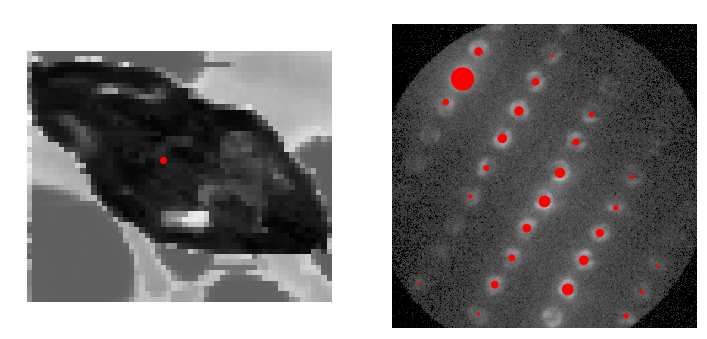

In [6]:
# Show

power=0.3
size_scale_factor = 500       # Set to zero to make all points the same size

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,12))
ax1.matshow(np.average(dc.data4D,axis=(2,3)))
ax1.scatter(Ry,Rx,color='r')
ax2.matshow(DP**power)
ax2.scatter(peaks.data['qy'],peaks.data['qx'],color='r',s=size_scale_factor*peaks.data['intensity']/np.max(peaks.data['intensity']))
ax1.axis('off')
ax2.axis('off')
plt.show()

#### Several DPs

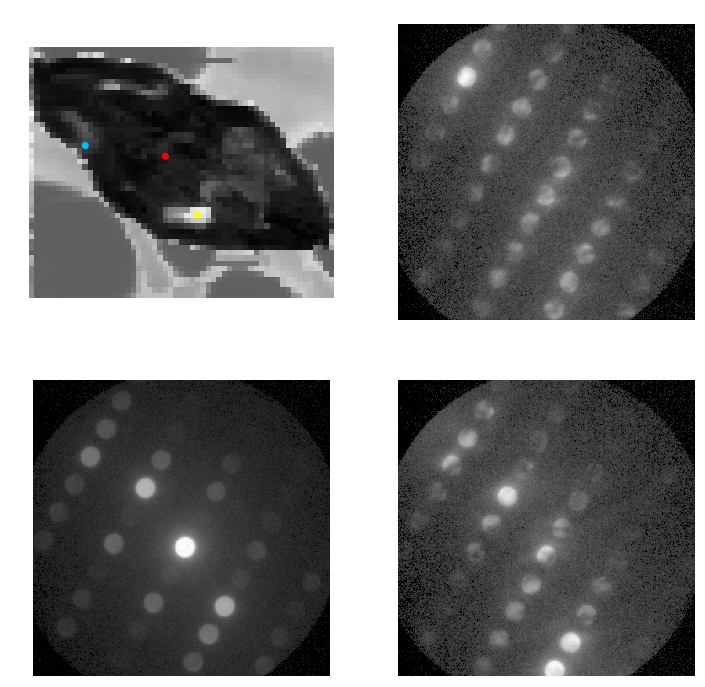

In [7]:
# Select a few DPs

Rxs=(20,31,18)
Rys=(25,31,10)
power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(Rys,Rxs,color=('r','yellow','deepskyblue'))
ax12.matshow(dc.data4D[Rxs[0],Rys[0],:,:]**power)
ax21.matshow(dc.data4D[Rxs[1],Rys[1],:,:]**power)
ax22.matshow(dc.data4D[Rxs[2],Rys[2],:,:]**power)

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

In [8]:
# Get peaks

corrPower = 0.8
sigma = 2
edgeBoundary = 20
maxNumPeaks = 70
minPeakSpacing = 50
minRelativeIntensity = 0.001

peaks = find_Bragg_disks_selected(dc, probe_kernel.data2D, Rxs, Rys,
                                  corrPower=corrPower,
                                  sigma=sigma,
                                  edgeBoundary=edgeBoundary,
                                  minRelativeIntensity=minRelativeIntensity,
                                  minPeakSpacing=minPeakSpacing,
                                  maxNumPeaks=maxNumPeaks)

Analyzed 3 diffraction patterns in 0h 0m 0s


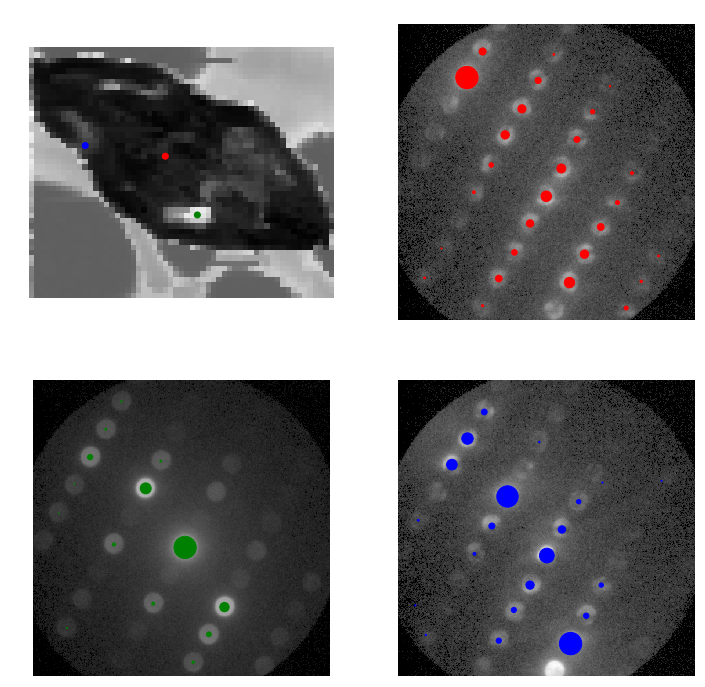

In [9]:
# Show

power=0.3
size_scale_factor = 500       # Set to zero to make all points the same size

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(Rys,Rxs,color=('r','g','b'))
ax12.matshow(dc.data4D[Rxs[0],Rys[0],:,:]**power)
ax21.matshow(dc.data4D[Rxs[1],Rys[1],:,:]**power)
ax22.matshow(dc.data4D[Rxs[2],Rys[2],:,:]**power)

if size_scale_factor == 0:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r')
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g')
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b')
else:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r',s=size_scale_factor*peaks[0].data['intensity']/np.max(peaks[0].data['intensity']))
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g',s=size_scale_factor*peaks[1].data['intensity']/np.max(peaks[1].data['intensity']))
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b',s=size_scale_factor*peaks[2].data['intensity']/np.max(peaks[2].data['intensity']))


ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

#### All DPs

In [ ]:
# Get peaks

corrPower = 0.8
sigma = 2
edgeBoundary = 20
maxNumPeaks = 70
minPeakSpacing = 50
minRelativeIntensity = 0.001
verbose = True

peaks = find_Bragg_disks(dc, probe_kernel.data2D,
                         corrPower=corrPower,
                         sigma=sigma,
                         edgeBoundary=edgeBoundary,
                         minRelativeIntensity=minRelativeIntensity,
                         minPeakSpacing=minPeakSpacing,
                         maxNumPeaks=maxNumPeaks,
                         verbose=verbose)

Analyzing scan position 0, 0...
Analyzing scan position 0, 1...
Analyzing scan position 0, 2...
Analyzing scan position 0, 3...
Analyzing scan position 0, 4...
Analyzing scan position 0, 5...
Analyzing scan position 0, 6...
Analyzing scan position 0, 7...
Analyzing scan position 0, 8...
Analyzing scan position 0, 9...
Analyzing scan position 0, 10...
Analyzing scan position 0, 11...
Analyzing scan position 0, 12...
Analyzing scan position 0, 13...
Analyzing scan position 0, 14...
Analyzing scan position 0, 15...
Analyzing scan position 0, 16...
Analyzing scan position 0, 17...
Analyzing scan position 0, 18...
Analyzing scan position 0, 19...
Analyzing scan position 0, 20...
Analyzing scan position 0, 21...
Analyzing scan position 0, 22...
Analyzing scan position 0, 23...
Analyzing scan position 0, 24...
Analyzing scan position 0, 25...
Analyzing scan position 0, 26...
Analyzing scan position 0, 27...
Analyzing scan position 0, 28...
Analyzing scan position 0, 29...
Analyzing scan posit

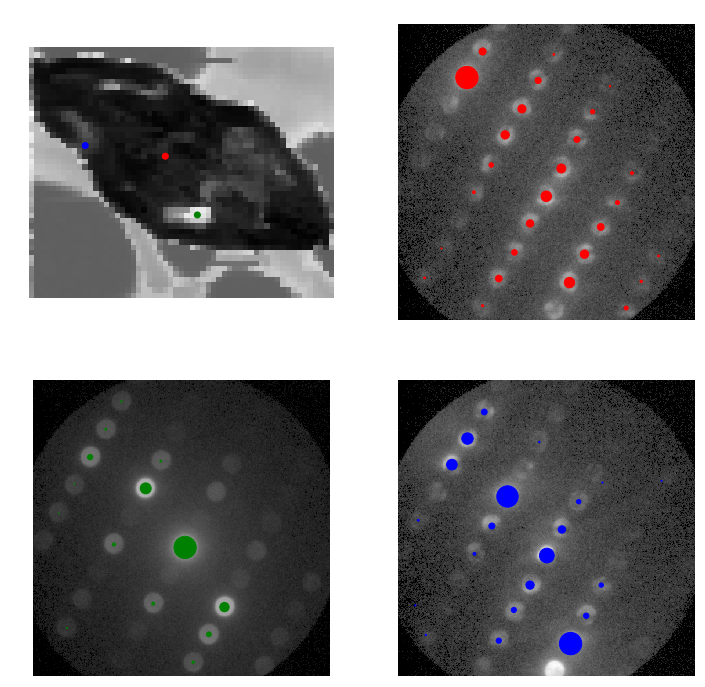

In [14]:
# Show

Rxs=(20,31,18)
Rys=(25,31,10)
power=0.3
size_scale_factor = 500       # Set to zero to make all points the same size

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(Rys,Rxs,color=('r','g','b'))
ax12.matshow(dc.data4D[Rxs[0],Rys[0],:,:]**power)
ax21.matshow(dc.data4D[Rxs[1],Rys[1],:,:]**power)
ax22.matshow(dc.data4D[Rxs[2],Rys[2],:,:]**power)

peaks0 = peaks.get_pointlist(Rxs[0],Rys[0])
peaks1 = peaks.get_pointlist(Rxs[1],Rys[1])
peaks2 = peaks.get_pointlist(Rxs[2],Rys[2])
if size_scale_factor == 0:
    ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r')
    ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g')
    ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b')
else:
    ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=size_scale_factor*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
    ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=size_scale_factor*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
    ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=size_scale_factor*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()